In [975]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [976]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
encode = LabelEncoder()

In [977]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [978]:
from sklearn.naive_bayes import MultinomialNB as MNB

# **Q1**

In [979]:
data_1=pd.read_csv('/content/drive/MyDrive/PRML Lab 4/titanic.csv')

In [980]:
data_1.columns

Index(['PassengerId', 'Name', 'Pclass', 'Sex', 'Age', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Survived'],
      dtype='object')

1) Data pre-processing

In [981]:
data_1=data_1.drop(columns=['PassengerId', 'Name', 'Age','Ticket', 'Fare','Cabin'])

In [982]:
# data_1.columns
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Sex       891 non-null    object
 2   Embarked  889 non-null    object
 3   Survived  891 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [983]:
data_1=data_1.dropna()
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    889 non-null    int64 
 1   Sex       889 non-null    object
 2   Embarked  889 non-null    object
 3   Survived  889 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 34.7+ KB


In [984]:
def encode_data(data):
    y=data.columns
    for i in y:
        if(type(data[i][0])==type("2")):
            x=encode.fit_transform(data[i])
            data[i]=x

    return(data)
data_1=encode_data(data_1)

In [985]:
def split_data(data,frac_training,frac_testing):
    training_data = data.sample(frac = frac_training)
    testing_data= data.drop(training_data.index)
    return(training_data,testing_data)

training_data_1,testing_data_1=split_data(data_1,0.75,0.25)

3) Implementing classifier from scratch 

In [986]:
def classwise_classifier(data,target):
    a={}
    col=list(data.columns)
    for j in range(0,len(col)):
        # if(j!=target):
            a[j]={}
            temp=np.unique(data[col[j]],return_counts=True)
            for k in range(0,len(temp[0])):
                a[j][temp[0][k]]=temp[1][k]
    return(a)
def nb_classifier(data,target):
    element=np.unique(data[target])
    classi={}
    for i in element:
        sub_data=data.where(data[target]==i).dropna()
        sub_data=sub_data.drop(columns=target)
        a=classwise_classifier(sub_data,target)
        
        classi[i]=a
    return(classi)

In [987]:
def prior_calcul(data,target):
    element,count=np.unique(data[target],return_counts=True)
    lost={}
    for i in range(0,len(element)):
        lost[element[i]]=count[i]/np.sum(count)
    return(lost)

In [988]:
def individual_prediction(data,classifier,target,prior_list):
    predict=0
    max_val=0
    element=np.unique(target)
    for i in element:
        val=prior_list[i] # later initialization to be changed to probability of class
        a=classifier[i]
        for j in range(0,len(data)): # for every feature
            if(data[j] in a[j].keys()):
                condi_prob_xj=(a[j][data[j]])/sum(a[j].values())
            else:
                condi_prob_xj=0
            val=val*condi_prob_xj
        if(max_val<=val):
          predict=i
          max_val=val
    return(predict)
def prediction(data,classifier,target,prior_list):
    converted_data=data.to_numpy()
    predict_list=[]
    for i in range(0,len(converted_data)):
        predict_list.append(individual_prediction(converted_data[i],classifier,target,prior_list))
    return(predict_list)

In [989]:
def accuracy(predicted,actual):
    correct_prediction=0
    for i in range(0,len(predicted)):
        if(predicted[i]==actual[i]):
            correct_prediction+=1
    return((correct_prediction*100)/len(predicted))


4) Cross validation

In [990]:
def k_fold_cross_validation(data,k=5):
    cv_score=0
    accu=[]
    data_left=data
    for i in range(0,k):
        train=data_left.sample(frac=1/(k-i)) 
        data_left=data_left.drop(train.index)
        test=data.drop(train.index)

        classifier=nb_classifier(train,'Survived')
        prior_list=prior_calcul(train,'Survived')

        actual=list(test['Survived'])
        x_test=test.drop(columns='Survived')

        pred=prediction(x_test,classifier,[0,1],prior_list)
        cv_score+=accuracy(pred,actual)
        accu.append(accuracy(pred,actual))
    return(cv_score/k,accu)

In [991]:
cv_score_1,individual_accuracy=k_fold_cross_validation(training_data_1,5)
print(cv_score_1)

78.224803423488


5) Visualizing cross validation and printing top class for testing data

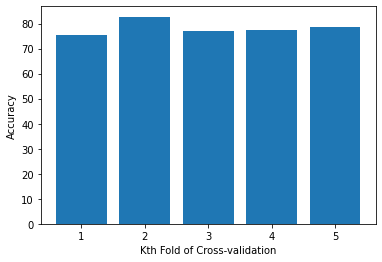

In [992]:
plt.bar([i for i in range(1,6)],individual_accuracy)
plt.xlabel('Kth Fold of Cross-validation')
plt.ylabel('Accuracy')
plt.show()

In [993]:
classifier_1=nb_classifier(training_data_1,'Survived')

In [994]:
prior_list=prior_calcul(training_data_1,'Survived')

In [995]:
def individual_prediction_part5(data,classifier,target,prior_list):
    predict=0
    max_val=0
    element=np.unique(target)
    for i in element:
        val=prior_list[i] # later initialization to be changed to probability of class
        a=classifier[i]
        for j in range(0,len(data)): # for every feature
            if(data[j] in a[j].keys()):
                condi_prob_xj=(a[j][data[j]])/sum(a[j].values())
            else:
                condi_prob_xj=0
            val=val*condi_prob_xj
        if(max_val<=val):
          predict=i
          max_val=val
    return(max_val)
def prediction_part5(data,classifier,target,prior_list):
    converted_data=data.to_numpy()
    predict_list=[]
    for i in range(0,len(converted_data)):
        predict_list.append(individual_prediction_part5(converted_data[i],classifier,target,prior_list))
    return(predict_list)

In [996]:
x_test_1=testing_data_1.drop(columns='Survived')
pred=prediction_part5(x_test_1,classifier_1,[0,1],prior_list)
actual=list(testing_data_1['Survived'])
# accuracy(pred,actual)

[0.028128110693703096, 0.05774187502381983, 0.27626653657109573, 0.028901729979745404, 0.05774187502381983, 0.07981033278720544, 0.028128110693703096, 0.07981033278720544, 0.27626653657109573, 0.0433525949696181, 0.27626653657109573, 0.27626653657109573, 0.27626653657109573, 0.05774187502381983, 0.27626653657109573, 0.06088002040554917, 0.27626653657109573, 0.27626653657109573, 0.07981033278720544, 0.27626653657109573, 0.27626653657109573, 0.00950182753556529, 0.27626653657109573, 0.05774187502381983, 0.013180029010763735, 0.05774187502381983, 0.27626653657109573, 0.04267877719151902, 0.028901729979745404, 0.27626653657109573, 0.27626653657109573, 0.04267877719151902, 0.05774187502381983, 0.05774187502381983, 0.27626653657109573, 0.00950182753556529, 0.27626653657109573, 0.27626653657109573, 0.27626653657109573, 0.06343898247188125, 0.028901729979745404, 0.013180029010763735, 0.27626653657109573, 0.028128110693703096, 0.07981033278720544, 0.05774187502381983, 0.028128110693703096, 0.27

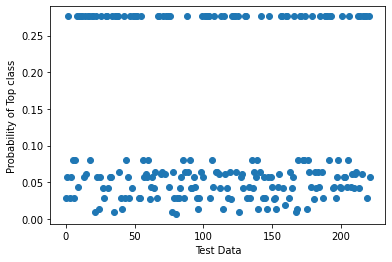

In [997]:
print(pred)
plt.scatter([i for i in range(0,len(pred))],list(pred))
plt.xlabel("Test Data")
plt.ylabel("Probability of Top class")
plt.show()

In [998]:
x_test_1=testing_data_1.drop(columns='Survived')
pred1=prediction(x_test_1,classifier_1,[0,1],prior_list)
actual=list(testing_data_1['Survived'])
accuracy(pred1,actual)

74.77477477477477

6) Comparing accuracy with inbuilt NB classifier

In [999]:
x_train_1=training_data_1.drop(columns='Survived')
y_train_1=training_data_1[['Survived']]

y_test_1=testing_data_1[['Survived']]

In [1000]:
mnb=MNB()
mnb.fit(x_train_1,y_train_1.values.ravel())
sk_predict=list(mnb.predict(x_test_1))
print(accuracy(sk_predict,actual))

60.810810810810814


7) Implementing some other model

In [1001]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc=DTC()
dtc.fit(x_train_1,y_train_1.values.ravel())
dtc_predict=list(dtc.predict(x_test_1))
print(accuracy(dtc_predict,actual))

78.82882882882883


In [1002]:
def k_fold_cross_validation_dtc(data,k=5):
    cv_score=0
    accu=[]
    data_left=data
    for i in range(0,k):
        train=data_left.sample(frac=1/(k-i)) 
        data_left=data_left.drop(train.index)
        test=data.drop(train.index)

        x_train=train.drop(columns='Survived')
        y_train=train[['Survived']]
        x_test=test.drop(columns='Survived')
        y_test=test[['Survived']]
        dtc=DTC()
        dtc.fit(x_train,y_train)
        y_pred=list(dtc.predict(x_test))
        cv_score+=accuracy(y_pred,list(y_test['Survived']))
        accu.append(accuracy(y_pred,list(y_test['Survived'])))
    return(cv_score/k,accu)
cv_dtc,accu_dtc=k_fold_cross_validation_dtc(training_data_1)
print(cv_dtc)

79.27201692068779


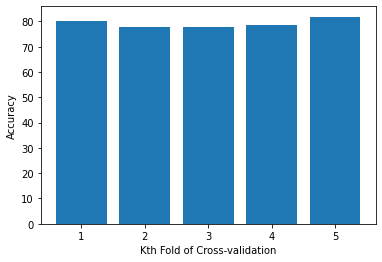

In [1003]:
plt.bar([i for i in range(1,6)],accu_dtc)
plt.xlabel('Kth Fold of Cross-validation')
plt.ylabel('Accuracy')
plt.show()

# **Q2**

In [1004]:
data_2=pd.read_csv('/content/drive/MyDrive/PRML Lab 4/dataset.csv')

In [1005]:
from matplotlib.axis import Axis

In [1006]:
# print(data_2.info())
data_2=data_2.dropna()
# print(data_2.info())
data_2=data_2.to_numpy()
data_2=pd.DataFrame(data_2,columns=['Area','Perimeter','Compactness','Length of kernel','Width of kernel','Asymmetry coefficient','Length of kernel groove','Class'])

1) Plotting distribution of data

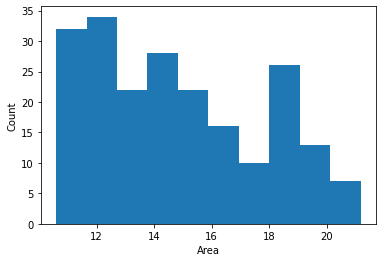

In [1007]:
plt.hist(data_2['Area'])
plt.xlabel('Area')
plt.ylabel('Count')
plt.show()

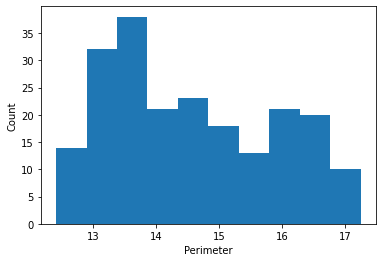

In [1008]:
plt.hist(data_2['Perimeter'])
plt.xlabel('Perimeter')
plt.ylabel('Count')
plt.show()

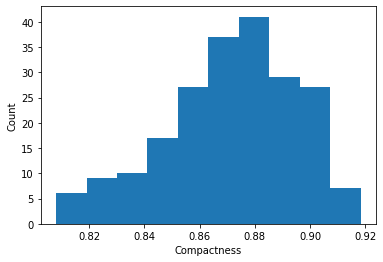

In [1009]:
plt.hist(data_2['Compactness'])
plt.xlabel('Compactness')
plt.ylabel('Count')
plt.show()

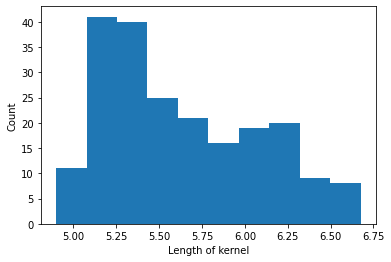

In [1010]:
plt.hist(data_2['Length of kernel'])
plt.xlabel('Length of kernel')
plt.ylabel('Count')
plt.show()

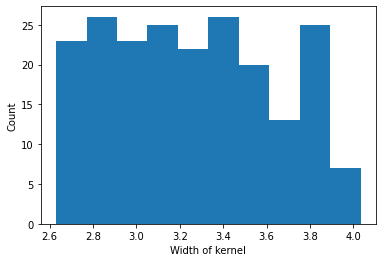

In [1011]:
plt.hist(data_2['Width of kernel'])
plt.xlabel('Width of kernel')
plt.ylabel('Count')
plt.show()

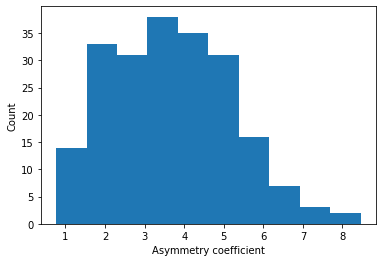

In [1012]:
plt.hist(data_2['Asymmetry coefficient'])
plt.xlabel('Asymmetry coefficient')
plt.ylabel('Count')
plt.show()

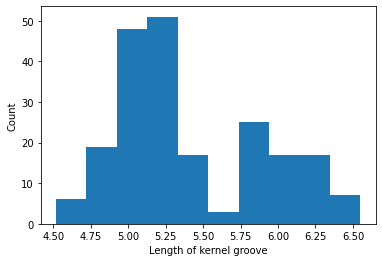

In [1013]:
plt.hist(data_2['Length of kernel groove'])
plt.xlabel('Length of kernel groove')
plt.ylabel('Count')
plt.show()

2) Prior probablility for all classes

In [1014]:
prior_list_2=prior_calcul(data_2,'Class')
print(prior_list_2)

{1.0: 0.3333333333333333, 2.0: 0.3333333333333333, 3.0: 0.3333333333333333}


In [1015]:
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of kernel         210 non-null    float64
 4   Width of kernel          210 non-null    float64
 5   Asymmetry coefficient    210 non-null    float64
 6   Length of kernel groove  210 non-null    float64
 7   Class                    210 non-null    float64
dtypes: float64(8)
memory usage: 13.2 KB
None


3) Binning of data

In [1016]:
def entropy_data(data):
    value,counts=np.unique(data,return_counts=True)
    entropy = 0
    for i in range (0,len(value)):
        p = (counts[i])/np.sum(counts)
        entropy = entropy - (p * np.log2(p))
    return(entropy)

In [1017]:
def binning(data,ind,col,target):
    tl=len(data[col])
    entro_min=2**30
    j=0
    a=np.unique(data[col])
    rang=a[-1]-a[0]
    for i in range(1,10):
        data_left=data
        e=[]
        for k in range(0,i):
            sub_data=data_left.where(data[col]<=(a[0]+(k+1)*(rang/i)) ).dropna()
            data_left=data.drop(sub_data.index)
            e.append((len(sub_data))*(entropy_data(sub_data[target])))
        entro=np.sum(e)
        if(entro < entro_min):
          entro_min=entro
          j=i
    copy_data=data.to_numpy()
    for i in range(0,tl):
        copy_data[i][ind]=int(((copy_data[i][ind]-a[0]))/(rang/j))
       
    updated_data=pd.DataFrame(copy_data,columns=data.columns)
    return(updated_data)
def complete_data_binning(data):
    y=['Area','Perimeter','Compactness','Length of kernel','Width of kernel','Asymmetry coefficient','Length of kernel groove']
    for i in range(0, len(y)):
      data=binning(data,i,y[i],'Class')  
    return(data)

In [1018]:
copy_data_2=complete_data_binning(data_2)

4) Likelihood of each class

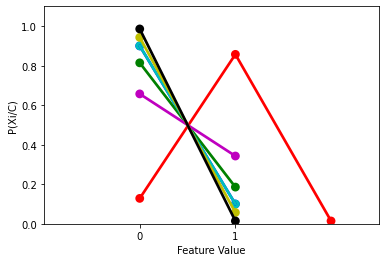

In [1019]:
def likelihood(data,col):
    a=[]
    for i in range(0,len(col)):
      b=[]
      count=np.unique(data[col[i]],return_counts=True)[1]
      for j in count:
        b.append(j/len(data))
      a.append(b)
    return(a)
y=['Area','Perimeter','Compactness','Length of kernel','Width of kernel','Asymmetry coefficient','Length of kernel groove']
l1=likelihood(data_2.where(data_2['Class']==1).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l1[i]))],l1[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(Xi/C)")
plt.show()

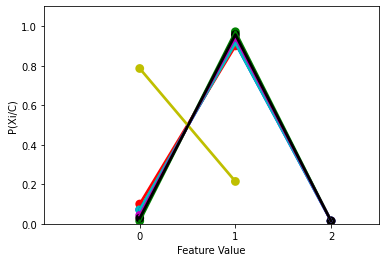

In [1020]:
l2=likelihood(data_2.where(data_2['Class']==2).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l2[i]))],l2[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(Xi/C)")
plt.show()

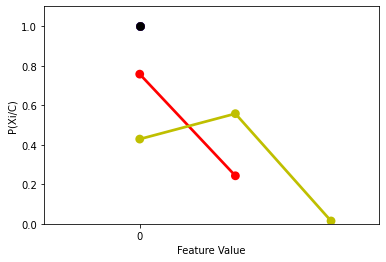

In [1021]:
l3=likelihood(data_2.where(data_2['Class']==3).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l3[i]))],l3[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(Xi/C)")
plt.show()

5) Unique element of each class for each feature

In [1022]:
def uniq_count(data,col):
    a=[]
    for i in range(0,len(col)):
      b=np.unique(data[col[i]],return_counts=True)[1]
      a.append(b)
    return(a)
uc_1=uniq_count(data_2.where(data_2['Class']==1).dropna(),y)
uc_2=uniq_count(data_2.where(data_2['Class']==2).dropna(),y)
uc_3=uniq_count(data_2.where(data_2['Class']==3).dropna(),y)

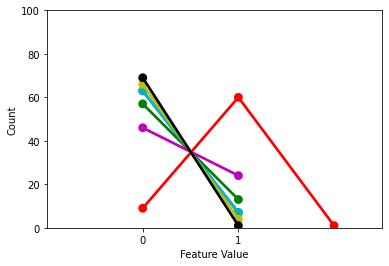

In [1023]:
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(uc_1[i]))],uc_1[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5,0,100])
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.show()

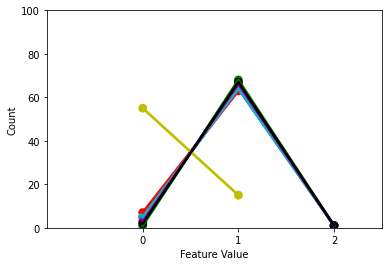

In [1024]:
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(uc_2[i]))],uc_2[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5,0,100])
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.show()

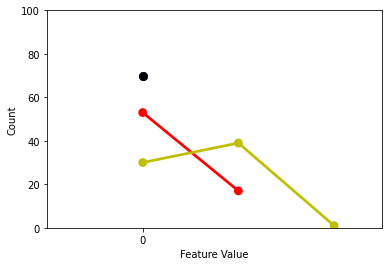

In [1025]:
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(uc_3[i]))],uc_3[i],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5,0,100])
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.show()

6) Posterior Probability

In [1026]:
prob_feature_value=[]
for i in range(0,7):
  abc=[0 for i in range(0,10)]
  for j in range(0,len(l1[i])):
    abc[j]+=(l1[i][j]*prior_list_2[1])
  for j in range(0,len(l2[i])):
    abc[j]+=(l2[i][j]*prior_list_2[2])
  for j in range(0,len(l3[i])):
    abc[j]+=(l3[i][j]*prior_list_2[3])
  prob_feature_value.append(abc)

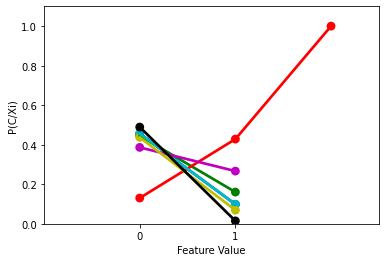

In [1027]:
l1=likelihood(data_2.where(data_2['Class']==1).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l1[i]))],[(l1[i][k]*(prior_list_2[1]/prob_feature_value[i][k])) for k in range(0,len(l1[i]))],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(C/Xi)")
plt.show()

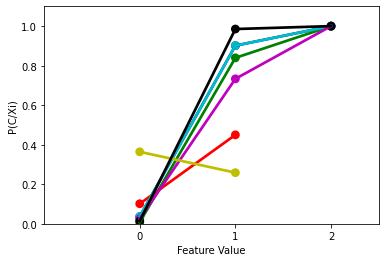

In [1028]:
l2=likelihood(data_2.where(data_2['Class']==2).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l2[i]))],[(l2[i][k]*(prior_list_2[1]/prob_feature_value[i][k])) for k in range(0,len(l2[i]))],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(C/Xi)")
plt.show()

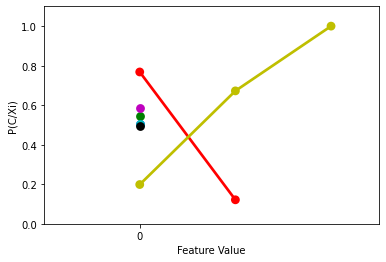

In [1029]:
l3=likelihood(data_2.where(data_2['Class']==3).dropna(),y)
for i in range(0,7):
  colr=['b','g','r','c','m','y','k']
  sns.pointplot([j for j in range(0,len(l3[i]))],[(l3[i][k]*(prior_list_2[1]/prob_feature_value[i][k])) for k in range(0,len(l3[i]))],linestyles='-',markers=['o'],color=colr[i])
plt.axis([-1, 2.5, 0, 1.1])
plt.xlabel("Feature Value")
plt.ylabel("P(C/Xi)")
plt.show()